In [32]:
# 1) column별 범주형인지 연속형인지 확인 및 분류
# 2) null값 뺐을 때의 분포 확인
# 3) 변수간 상관관계 확인
# 4) 쏘카 앱도 확인
# 5) start_hour와 accident_hour 차이를 통해 사고 몇시간 후에 일어났는지 확인
#    (단, 대여기간이 24시간 이하인 사람들만)
#    (지금보니, 3-4-5-6-2는 연속성을 가지는데 1이 문제. 이거 처리할 방법?)
#    (duration 3번부터는 반납시간 판정 불가. 경우의 수가 2가지 나옴)  
  
  
# 아쉬운점: 주중/주말 미구분

In [82]:
# ideation memo
# 보험 사기의 종류에는, 방법에는 뭐가 있을까?
# 단독범행 or 단체범행? 각각의 보험금의 차이가 있는가

In [4]:
# !pip install missingno

  Using cached missingno-0.4.2-py3-none-any.whl (9.7 kB)


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

In [2]:
# data 불러오기
socar_rd = pd.read_csv('datas/insurance_fraud_detect_data.csv')

In [3]:
# 모두 16000 non-null
socar_rd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fraud_YN               16000 non-null  int64  
 1   car_model              16000 non-null  int64  
 2   sharing_type           16000 non-null  int64  
 3   age_group              16000 non-null  int64  
 4   has_previous_accident  16000 non-null  int64  
 5   cumulative_use_count   16000 non-null  int64  
 6   b2b                    16000 non-null  int64  
 7   accident_ratio         16000 non-null  int64  
 8   pf_type                16000 non-null  int64  
 9   socarpass              16000 non-null  int64  
 10  socarsave              16000 non-null  int64  
 11  start_hour             16000 non-null  int64  
 12  duration               16000 non-null  int64  
 13  accident_hour          16000 non-null  int64  
 14  repair_cost            16000 non-null  float64
 15  in

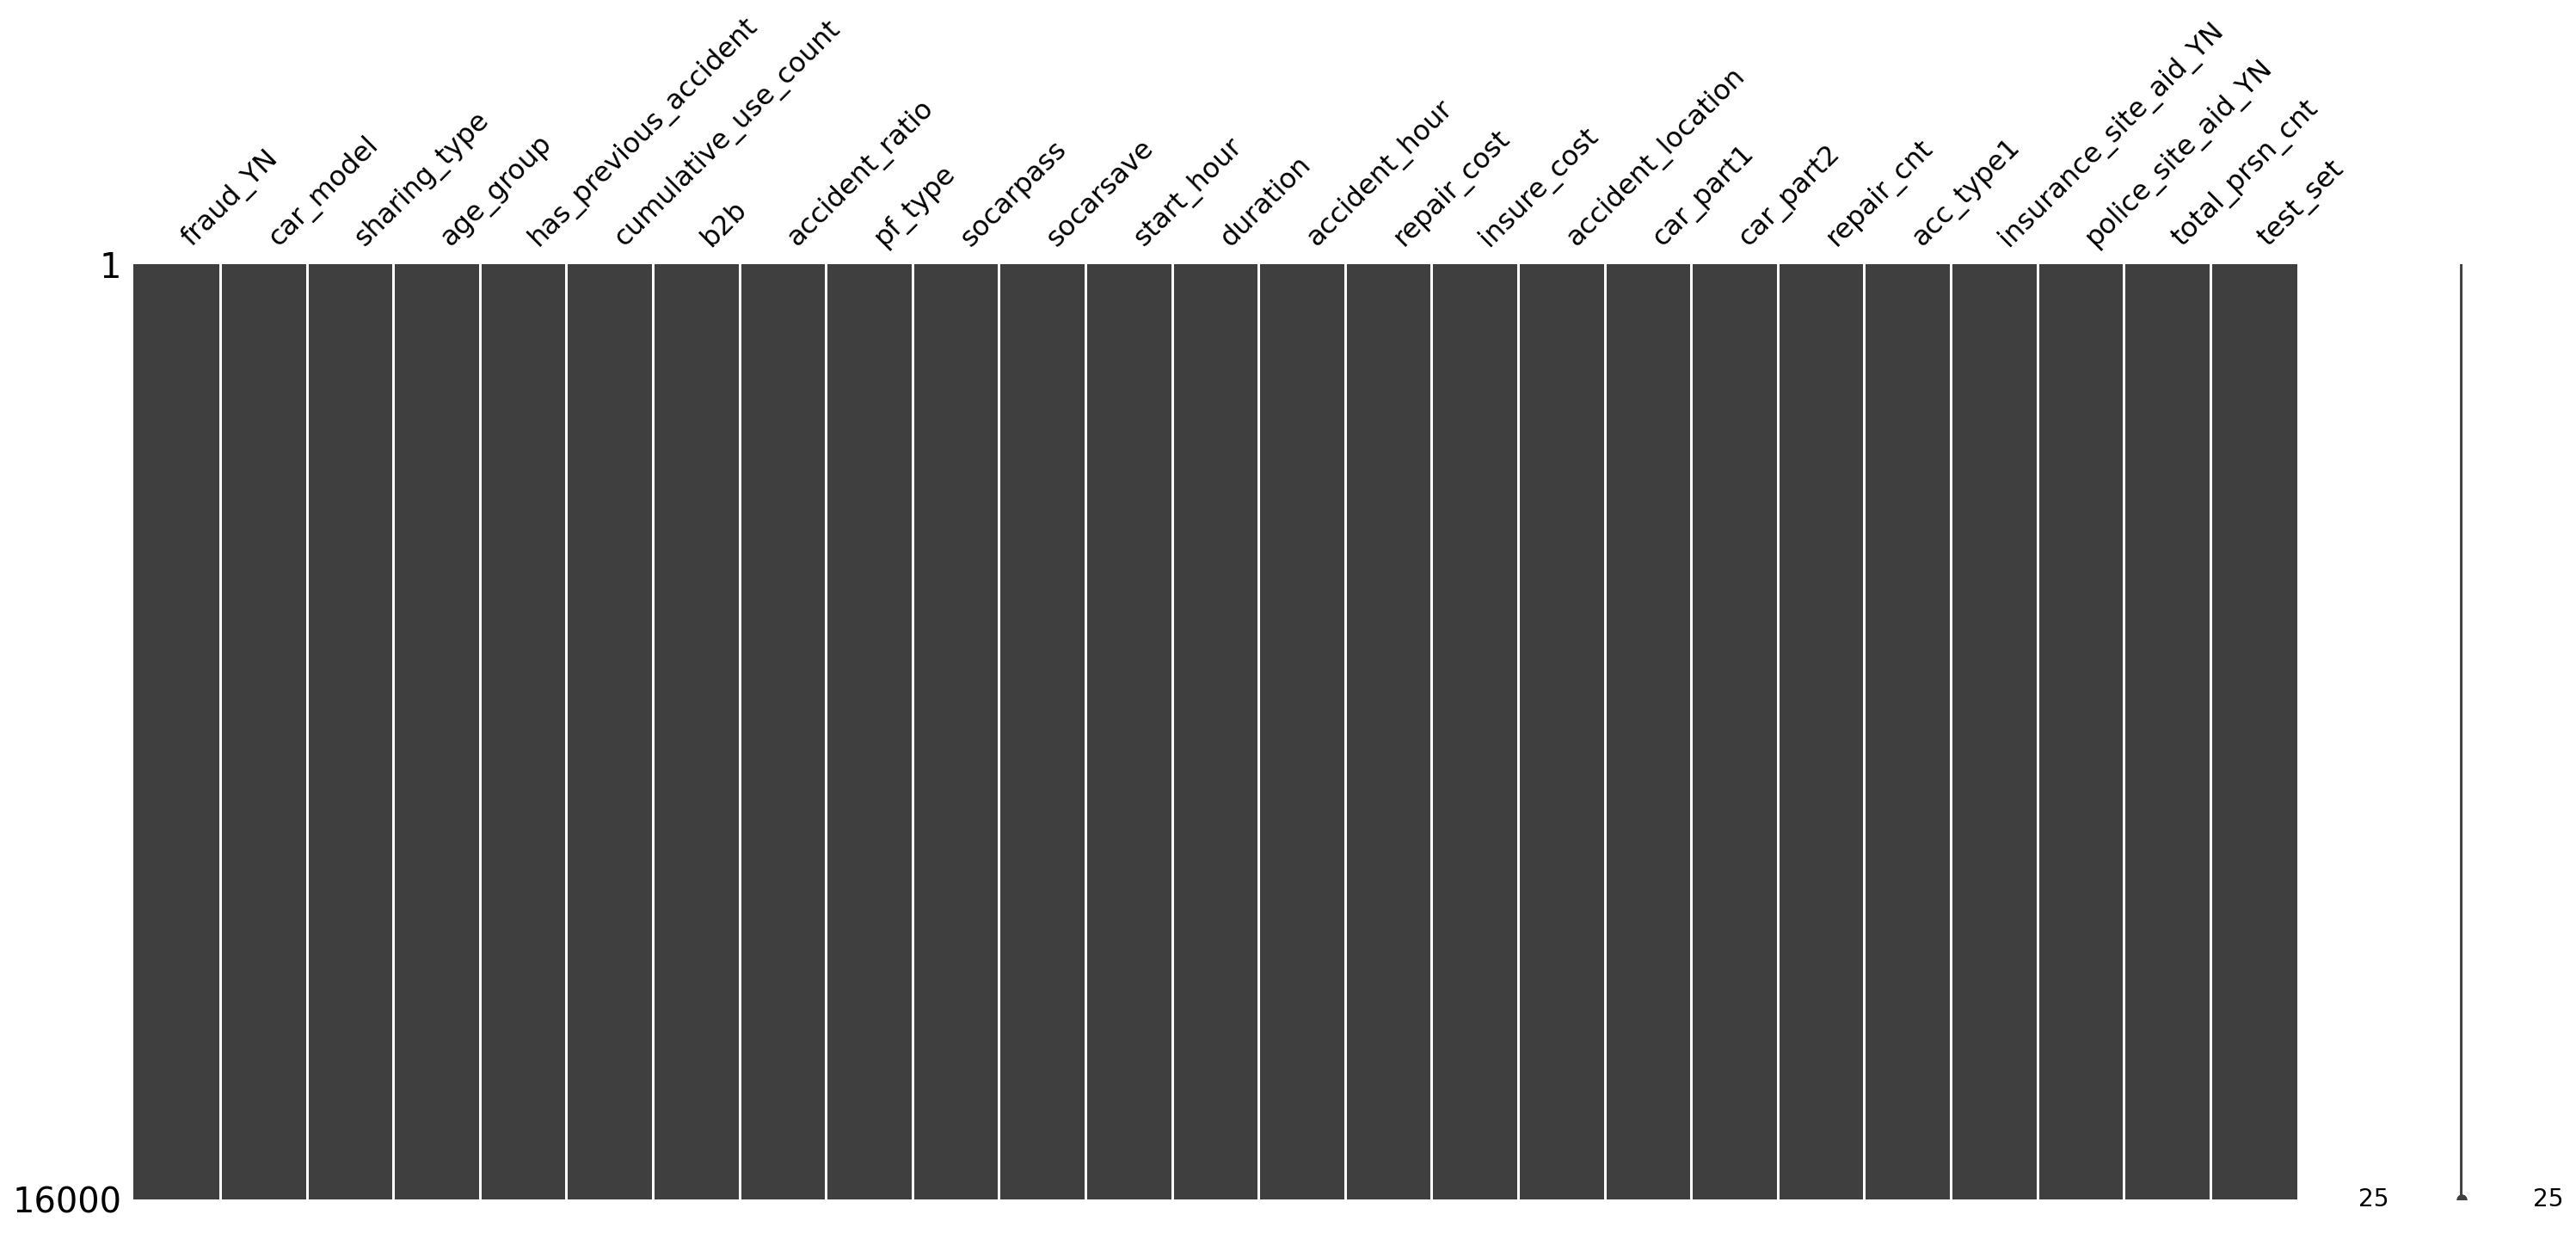

In [8]:
# missingno로 확인결과 null 없음
msno.matrix(socar_rd);

In [34]:
# null이 어떤 건 0이고 어떤 건 -1인데, 이거는 칼럼별로 분리가 필요하겠다
socar_rd[socar_rd==0].count()

fraud_YN                 15959
car_model                    0
sharing_type             13751
age_group                    0
has_previous_accident    14635
cumulative_use_count         0
b2b                      15895
accident_ratio            1364
pf_type                      0
socarpass                13394
socarsave                14719
start_hour                   0
duration                     0
accident_hour                0
repair_cost               6006
insure_cost              10424
accident_location         4778
car_part1                10731
car_part2                13228
repair_cnt                 271
acc_type1                11384
insurance_site_aid_YN    11325
police_site_aid_YN       11328
total_prsn_cnt            1997
test_set                 12879
dtype: int64

In [15]:
# test_size는 0.2 정도
socar_rd["test_set"].value_counts()

0    12879
1     3121
Name: test_set, dtype: int64

In [16]:
# 비대칭 데이터.. 일단 EDA는 train~test 구분없이 보는 걸로
socar_rd.fraud_YN.value_counts()

0    15959
1       41
Name: fraud_YN, dtype: int64

In [4]:
# fraud = YES와 NO별로 구분해서 특징 파악해보자 (둘 사이의 양상에 어떤 차이점이 있지 않을까 해서)
fraud_yes = socar_rd[socar_rd["fraud_YN"]==1]
fraud_no = socar_rd[socar_rd["fraud_YN"]==0]

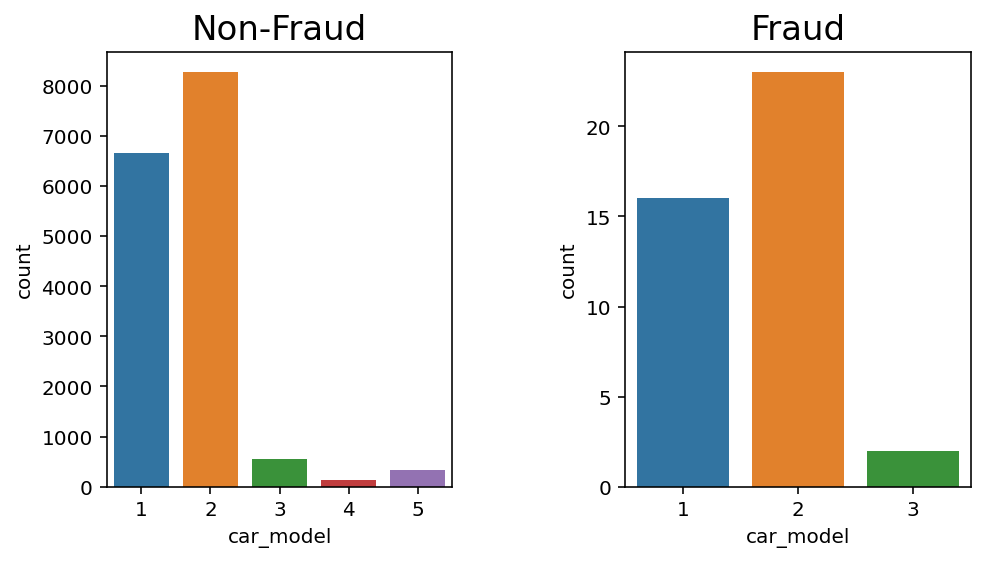

In [5]:
# car_model ->소수의 4,5 말고는 큰 차이는 느껴지지 않는다
fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(left=2, right=3, wspace=.5)

ax[0].set_title("Non-Fraud", fontsize=17)
sns.countplot(x=fraud_no["car_model"], ax=ax[0])


ax[1].set_title("Fraud", fontsize=17)
sns.countplot(x=fraud_yes["car_model"], ax=ax[1])
plt.show()

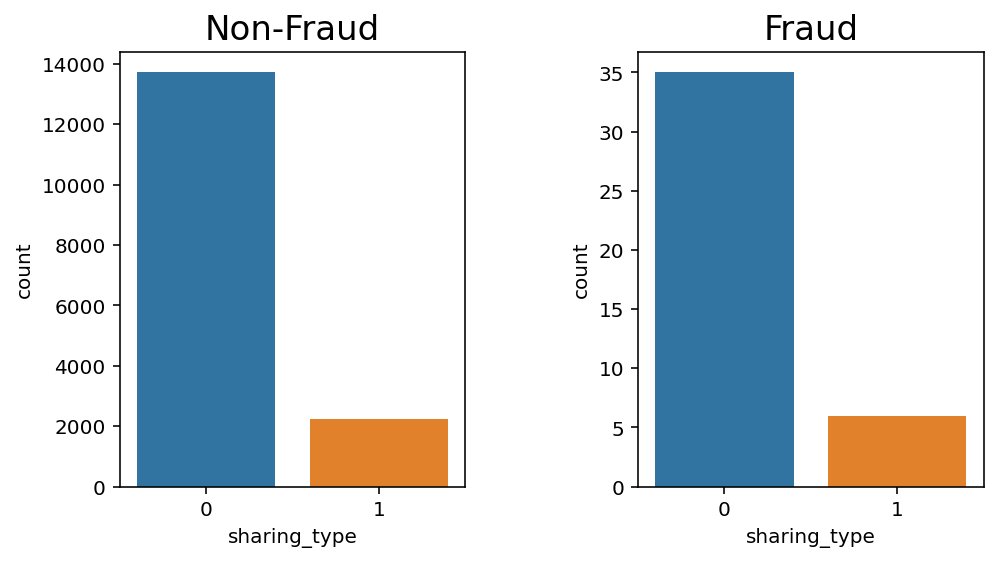

In [75]:
# sharing_type -> 거의 일치할 정도로 비슷한 비율
fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(left=2, right=3, wspace=.5)

ax[0].set_title("Non-Fraud", fontsize=17)
sns.countplot(x=fraud_no["sharing_type"], ax=ax[0])


ax[1].set_title("Fraud", fontsize=17)
sns.countplot(x=fraud_yes["sharing_type"], ax=ax[1])
plt.show()

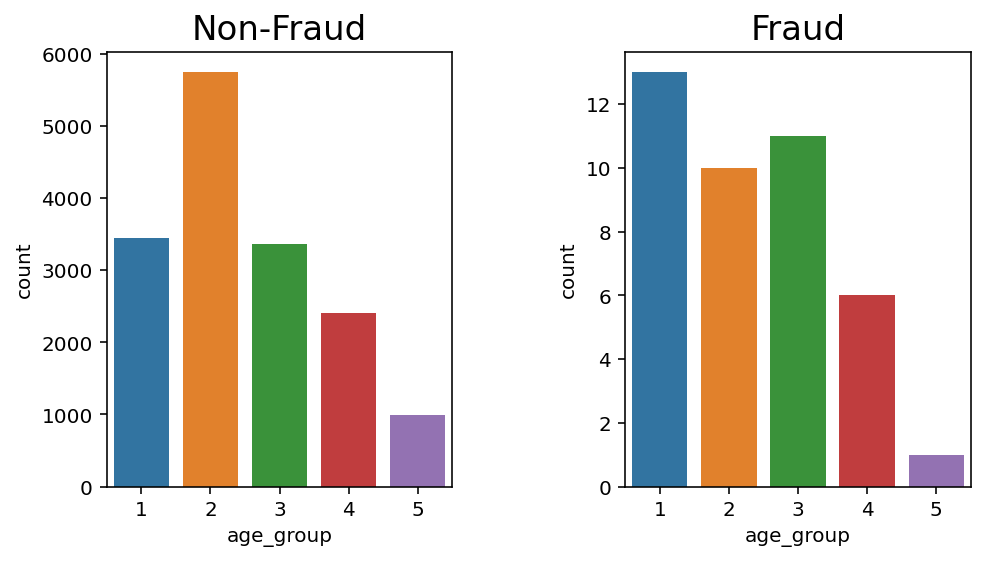

In [76]:
# age_group -> 연령대별로 다른 모양. 20초반, 20후반 사기비율이 높음. 
fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(left=2, right=3, wspace=.5)

ax[0].set_title("Non-Fraud", fontsize=17)
sns.countplot(x=fraud_no["age_group"], ax=ax[0])


ax[1].set_title("Fraud", fontsize=17)
sns.countplot(x=fraud_yes["age_group"], ax=ax[1])
plt.show()

In [20]:
pd.merge(round(fraud_no["age_group"].value_counts() / len(fraud_no) * 100, 2),
         round(fraud_yes["age_group"].value_counts() / len(fraud_yes) * 100, 2),
         left_index=True, right_index=True,
        ).sort_index()

,age_group_x,age_group_y
1,21.56,31.71
2,35.99,24.39
3,21.09,26.83
4,15.12,14.63
5,6.25,2.44


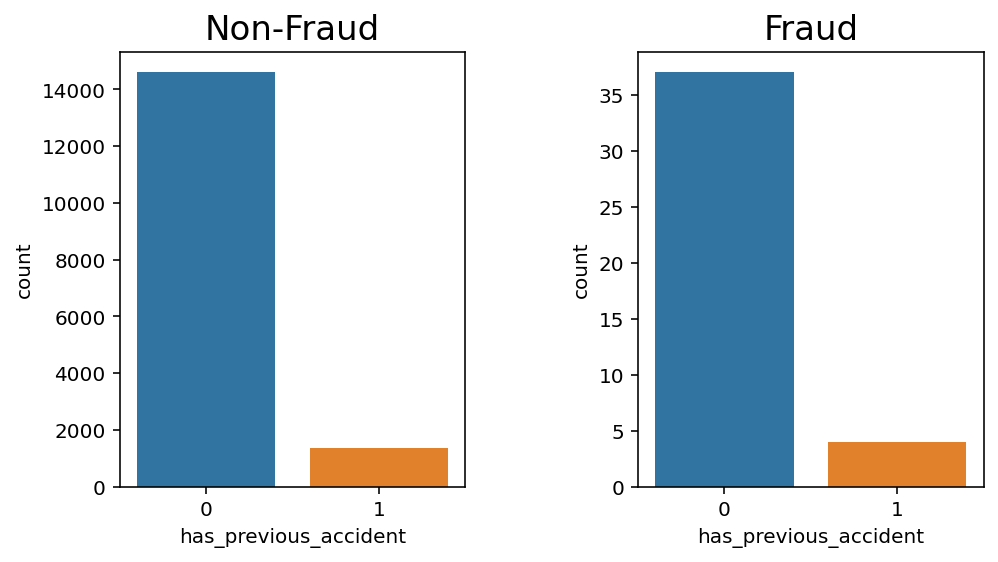

In [81]:
# has_previous_accident -> 거의 유사함. 사실 보험사기면 오히려 이게 적을 거 같기도 함. 추적 안되게 새로 가입을 하지 않을까.
fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(left=2, right=3, wspace=.5)

ax[0].set_title("Non-Fraud", fontsize=17)
sns.countplot(x=fraud_no["has_previous_accident"], ax=ax[0])


ax[1].set_title("Fraud", fontsize=17)
sns.countplot(x=fraud_yes["has_previous_accident"], ax=ax[1])
plt.show()

In [ ]:
# cumulative_use_count -> 이게 fraud는 적지 않을까? -> fraud에서 1이 많고 2(2~5회)가 적은건 예상과 일치. 그런데 4(11회~)도 많네..? 양극화
fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(left=2, right=3, wspace=.5)

ax[0].set_title("Non-Fraud", fontsize=17)
sns.countplot(x=fraud_no["cumulative_use_count"], ax=ax[0])


ax[1].set_title("Fraud", fontsize=17)
sns.countplot(x=fraud_yes["cumulative_use_count"], ax=ax[1])
plt.show()

In [21]:
pd.merge(round(fraud_no["cumulative_use_count"].value_counts() / len(fraud_no) * 100, 2),
         round(fraud_yes["cumulative_use_count"].value_counts() / len(fraud_yes) * 100, 2),
         left_index=True, right_index=True,
        ).sort_index()

,cumulative_use_count_x,cumulative_use_count_y
1,23.15,34.15
2,30.26,17.07
3,14.52,14.63
4,32.07,34.15


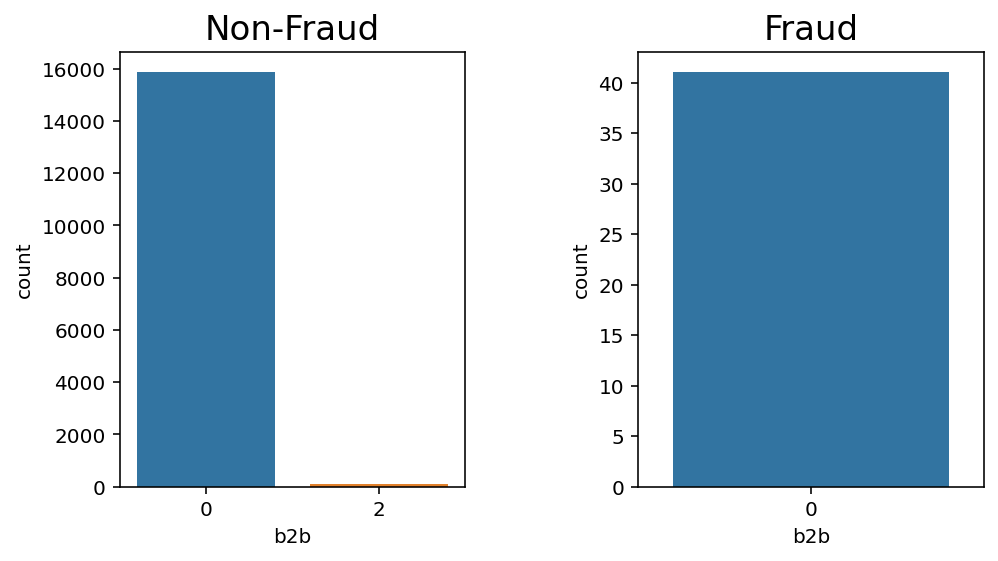

In [84]:
# b2b -> 이게 fraud는 거의 없지 않을까? -> 그래 있을 이유가 없지 자기가 받는 것도 아닌데.. -> 학습에 필요없을 듯?
fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(left=2, right=3, wspace=.5)

ax[0].set_title("Non-Fraud", fontsize=17)
sns.countplot(x=fraud_no["b2b"], ax=ax[0])


ax[1].set_title("Fraud", fontsize=17)
sns.countplot(x=fraud_yes["b2b"], ax=ax[1])
plt.show()

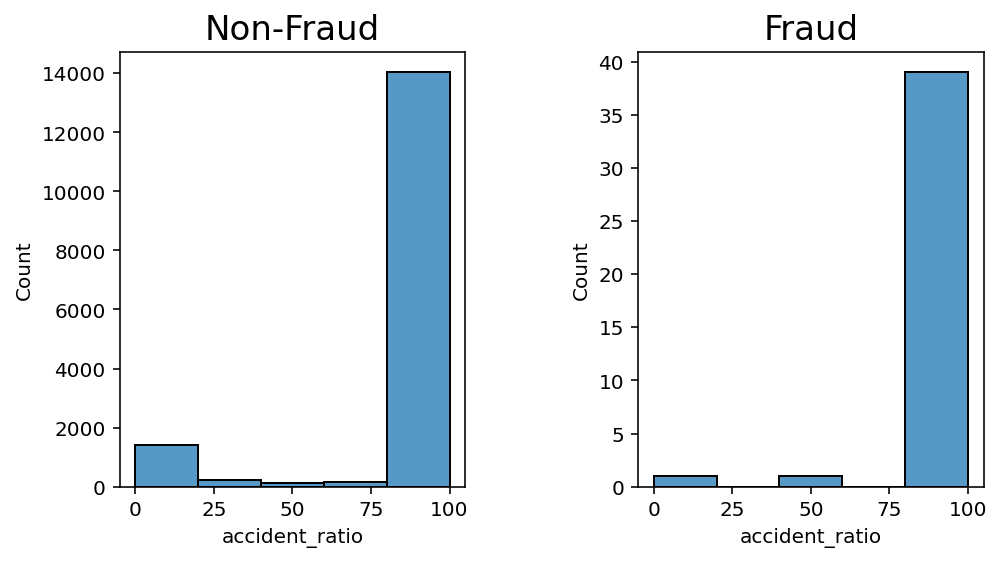

In [93]:
# accident_ratio -> 비율차이가 조금 있기는 한데 100이 절대다수인건 별 차이 없음.
fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(left=2, right=3, wspace=.5)

ax[0].set_title("Non-Fraud", fontsize=17)
sns.histplot(x=fraud_no["accident_ratio"], bins=5, ax=ax[0])


ax[1].set_title("Fraud", fontsize=17)
sns.histplot(x=fraud_yes["accident_ratio"], bins=5, ax=ax[1])
plt.show()

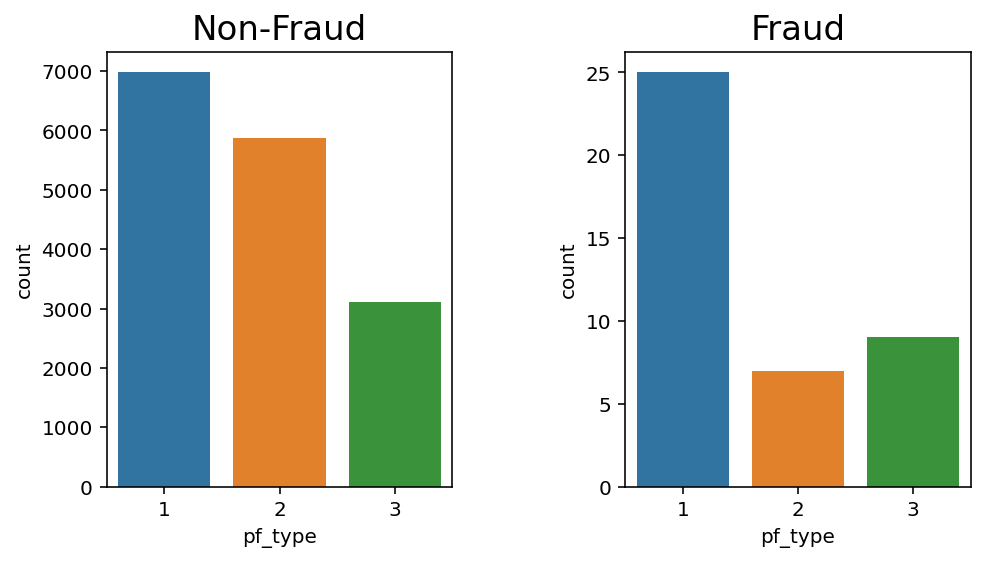

In [95]:
# pf_type -> Fraud는 몇천원 더 내고 가장 적게 부담하는 걸 고르지 않을까? -> 어느 정도 적중했으나 2,3으로 한 경우도 있어서 고민.
fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(left=2, right=3, wspace=.5)

ax[0].set_title("Non-Fraud", fontsize=17)
sns.countplot(x=fraud_no["pf_type"], ax=ax[0])


ax[1].set_title("Fraud", fontsize=17)
sns.countplot(x=fraud_yes["pf_type"], ax=ax[1])
plt.show()

In [22]:
pd.merge(round(fraud_no["pf_type"].value_counts() / len(fraud_no) * 100, 2),
         round(fraud_yes["pf_type"].value_counts() / len(fraud_yes) * 100, 2),
         left_index=True, right_index=True,
        ).sort_index()

,pf_type_x,pf_type_y
1,43.72,60.98
2,36.81,17.07
3,19.47,21.95


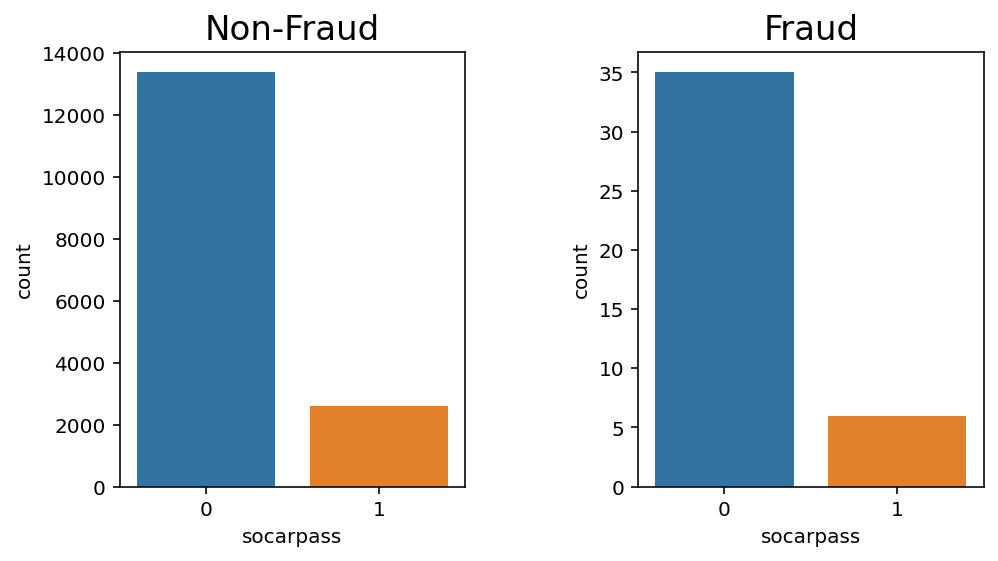

In [96]:
# socarpass -> 설마 이걸 쓰는데 보험사기를 칠까? -> 예상외로 큰 차이가 없다. 충성고객도 사기를 친다.
fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(left=2, right=3, wspace=.5)

ax[0].set_title("Non-Fraud", fontsize=17)
sns.countplot(x=fraud_no["socarpass"], ax=ax[0])


ax[1].set_title("Fraud", fontsize=17)
sns.countplot(x=fraud_yes["socarpass"], ax=ax[1])
plt.show()

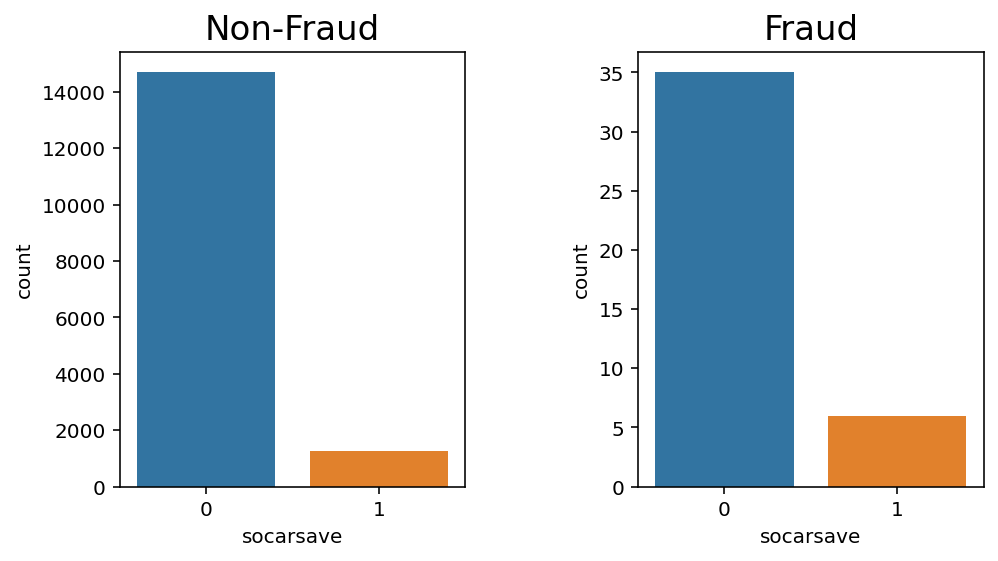

In [97]:
# socarsave -> 보험사기칠 때 이건 상관없으니 굳이 돈 아낄 필요 없어서 이걸 덜 쓰지 않을까? -> 오히려 더 쓰네..? 예상 틀림.
fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(left=2, right=3, wspace=.5)

ax[0].set_title("Non-Fraud", fontsize=17)
sns.countplot(x=fraud_no["socarsave"], ax=ax[0])


ax[1].set_title("Fraud", fontsize=17)
sns.countplot(x=fraud_yes["socarsave"], ax=ax[1])
plt.show()

In [199]:
pd.merge(pd.DataFrame(round(fraud_no["socarsave"].value_counts() / len(fraud_no) * 100, 2),).sort_index(),
        pd.DataFrame(round(fraud_yes["socarsave"].value_counts() / len(fraud_yes) * 100, 2)),
        left_index=True, right_index=True)

,socarsave_x,socarsave_y
0,92.01,85.37
1,7.99,14.63


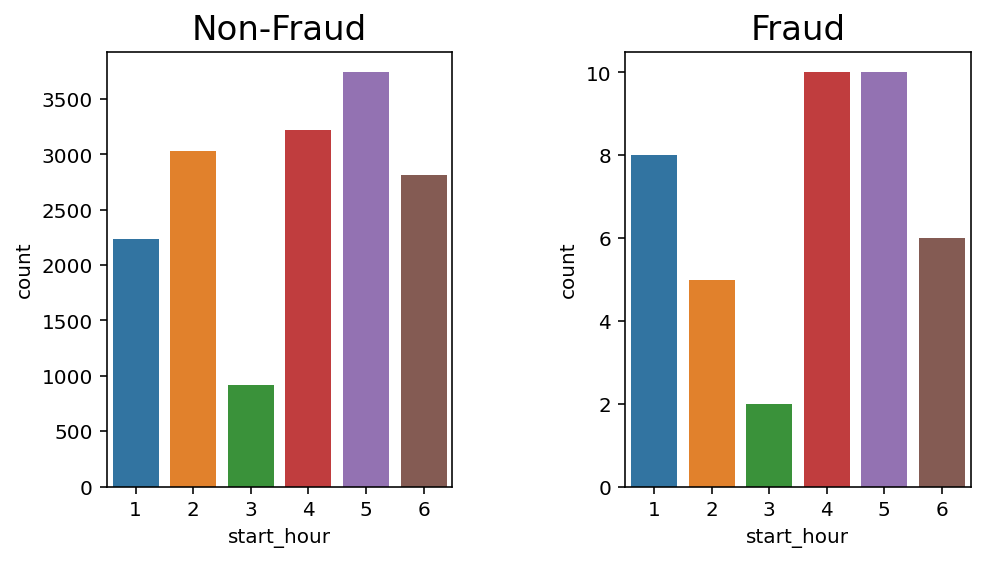

In [99]:
# start_hour -> 출근,점심시간 등 사기가 아닌 때처럼 수가 많은 건 의외. 그러나 비교적 퇴근시간에 적고 야밤에 많은 것은 유의한 차이로 보임.
# 사람 적을 때 사기내는 쪽과 사람 많아서 혼잡할 때 사기 내는 두 부류가 있는건 아닐까? 그 두 부류 간에 부류별 차이점이 있는지 확인해보기
fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(left=2, right=3, wspace=.5)

ax[0].set_title("Non-Fraud", fontsize=17)
sns.countplot(x=fraud_no["start_hour"], ax=ax[0])


ax[1].set_title("Fraud", fontsize=17)
sns.countplot(x=fraud_yes["start_hour"], ax=ax[1])
plt.show()

In [200]:
pd.merge(pd.DataFrame(round(fraud_no["start_hour"].value_counts() / len(fraud_no) * 100, 2),).sort_index(),
        pd.DataFrame(round(fraud_yes["start_hour"].value_counts() / len(fraud_yes) * 100, 2)),
        left_index=True, right_index=True)

,start_hour_x,start_hour_y
1,14.00,19.51
2,19.02,12.20
3,5.73,4.88
4,20.16,24.39
5,23.44,24.39
6,17.65,14.63


In [ ]:
pd.merge(round(fraud_no["start_hour"].value_counts() / len(fraud_no) * 100, 2),
         round(fraud_yes["start_hour"].value_counts() / len(fraud_yes) * 100, 2),
         left_index=True, right_index=True,
        ).sort_index()

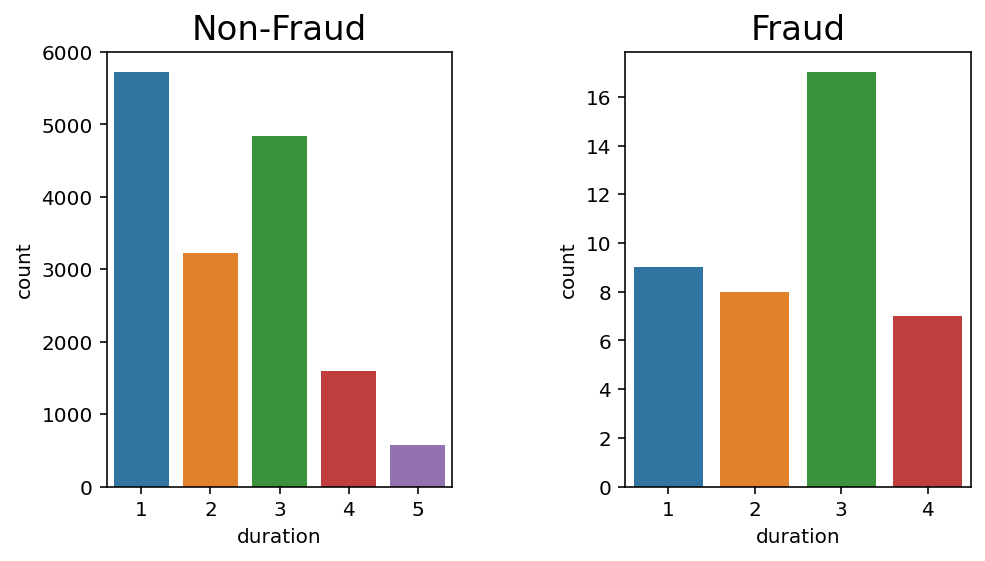

In [100]:
# duration -> 단시간이 많을 거라는 예상과는 반대로, 2~6, 6~10시간 등 단시간 비중이 적었고, 10~36시간 비율이 비교적 높았음.
# 보험사기를 치는데 몇시간이 아니라 반나절 이상을 빌린다.. 보험사기 패턴에 대한 재이해가 필요할 듯 싶다
fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(left=2, right=3, wspace=.5)

ax[0].set_title("Non-Fraud", fontsize=17)
sns.countplot(x=fraud_no["duration"], ax=ax[0])


ax[1].set_title("Fraud", fontsize=17)
sns.countplot(x=fraud_yes["duration"], ax=ax[1])
plt.show()

In [30]:
pd.merge(round(fraud_no["duration"].value_counts() / len(fraud_no) * 100, 2),
         round(fraud_yes["duration"].value_counts() / len(fraud_yes) * 100, 2),
         how = 'outer', left_index= True, right_index=True,
        ).sort_index()

,duration_x,duration_y
1,35.83,21.95
2,20.21,19.51
3,30.33,41.46
4,10.01,17.07
5,3.61,NaN


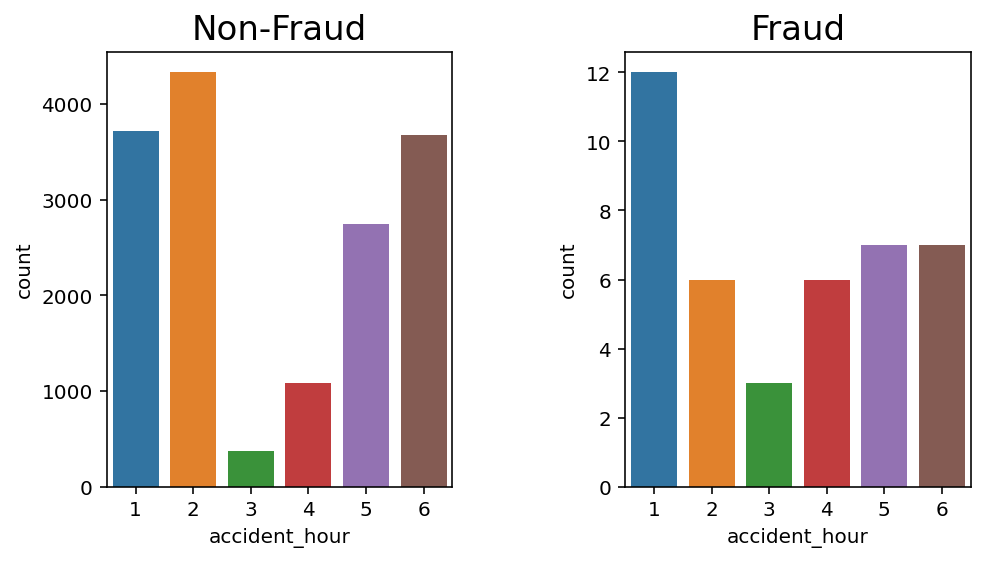

In [104]:
# accident_hour -> 정상사고는 퇴근시간>야밤=오후 순인 반면, 사기는 야밤에 압도적으로 많고, 퇴근시간에는 비교적 적으며, 출근시간에도 비교적 높음
fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(left=2, right=3, wspace=.5)

ax[0].set_title("Non-Fraud", fontsize=17)
sns.countplot(x=fraud_no[fraud_no["accident_hour"]!=-1]["accident_hour"], ax=ax[0]) # -1 36개는 제외


ax[1].set_title("Fraud", fontsize=17)
sns.countplot(x=fraud_yes["accident_hour"], ax=ax[1])
plt.show()

In [124]:
# accident_hour에 대해 비사기/사기로 구분하여 시간대별 비율을 비교해봄
pd.merge(pd.DataFrame(round(fraud_no["accident_hour"].value_counts() / len(fraud_no) * 100, 2),).sort_index(),
        pd.DataFrame(round(fraud_yes["accident_hour"].value_counts() / len(fraud_yes) * 100, 2)),
        left_index=True, right_index=True)

,accident_hour_x,accident_hour_y
1,23.28,29.27
2,27.14,14.63
3,2.32,7.32
4,6.82,14.63
5,17.20,17.07
6,23.02,17.07


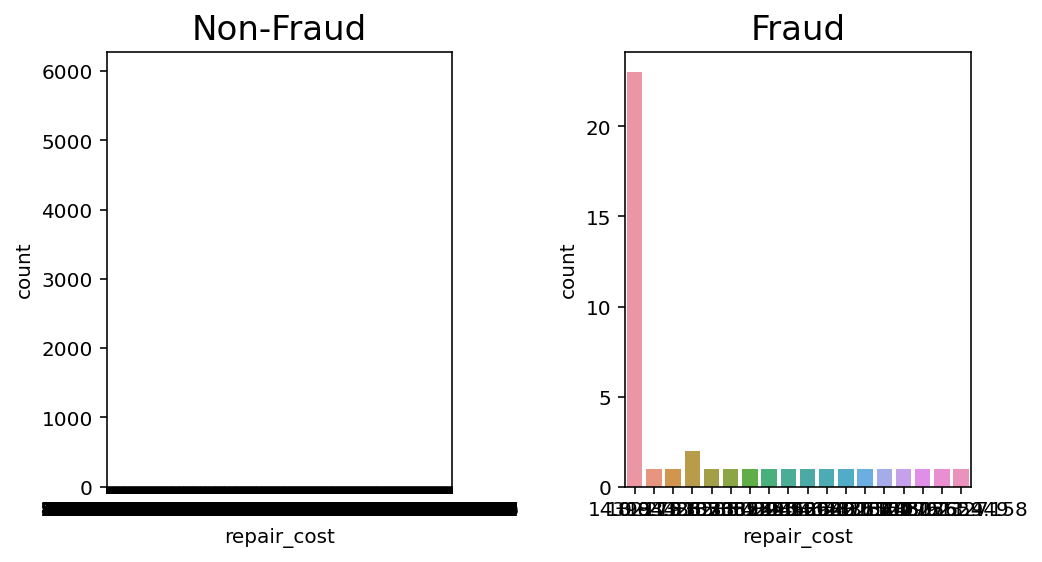

In [198]:
# repair_cost
fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(left=2, right=3, wspace=.5)

ax[0].set_title("Non-Fraud", fontsize=17)
sns.countplot(x=fraud_no["repair_cost"], ax=ax[0])


ax[1].set_title("Fraud", fontsize=17)
sns.countplot(x=fraud_yes["repair_cost"], ax=ax[1])
plt.show()

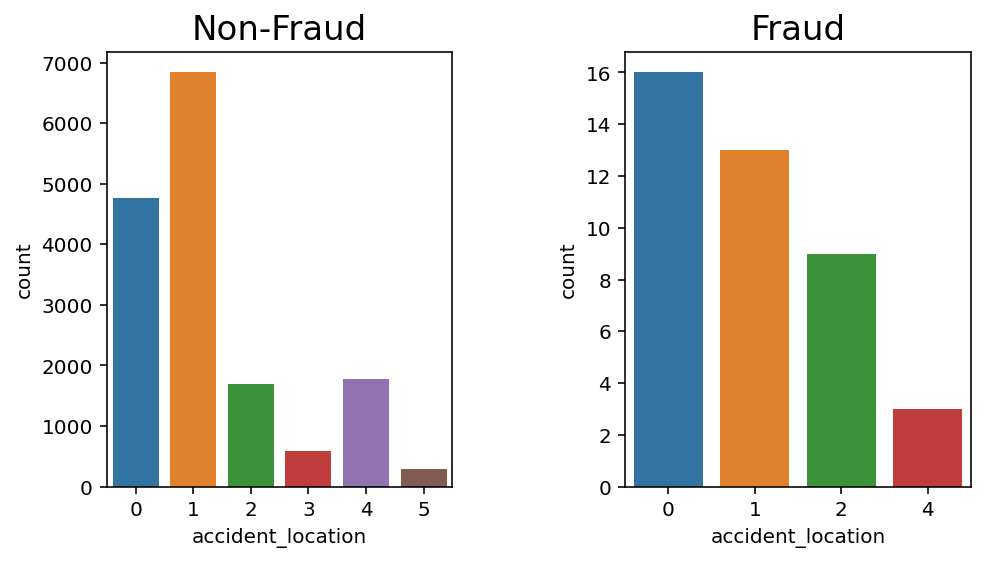

In [125]:
# accident_location -> 사기는 자기가 안다칠 거 같고 차량 손상은 적당히 일어나는 주차장에서 많고, 통제 어려운 고속도로 등은 적을거라 예상
# 어느정도 일치. 일반도로가 절반에 가까운 비사기와 달리, 사기는 컨트롤이 가능한 주차장과 이면도로가 10%p 가량 높았으며, 쏘카존 없고, 고속도로는 0
fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(left=2, right=3, wspace=.5)

ax[0].set_title("Non-Fraud", fontsize=17)
sns.countplot(x=fraud_no["accident_location"], ax=ax[0]) 


ax[1].set_title("Fraud", fontsize=17)
sns.countplot(x=fraud_yes["accident_location"], ax=ax[1])
plt.show()

In [128]:
# accident_location에 대해 비사기/사기로 구분하여 장소별 비율을 비교해봄
pd.merge(pd.DataFrame(round(fraud_no["accident_location"].value_counts() / len(fraud_no) * 100, 2),).sort_index(),
        pd.DataFrame(round(fraud_yes["accident_location"].value_counts() / len(fraud_yes) * 100, 2)),
        left_index=True, right_index=True)

,accident_location_x,accident_location_y
0,29.84,39.02
1,42.84,31.71
2,10.66,21.95
4,11.17,7.32


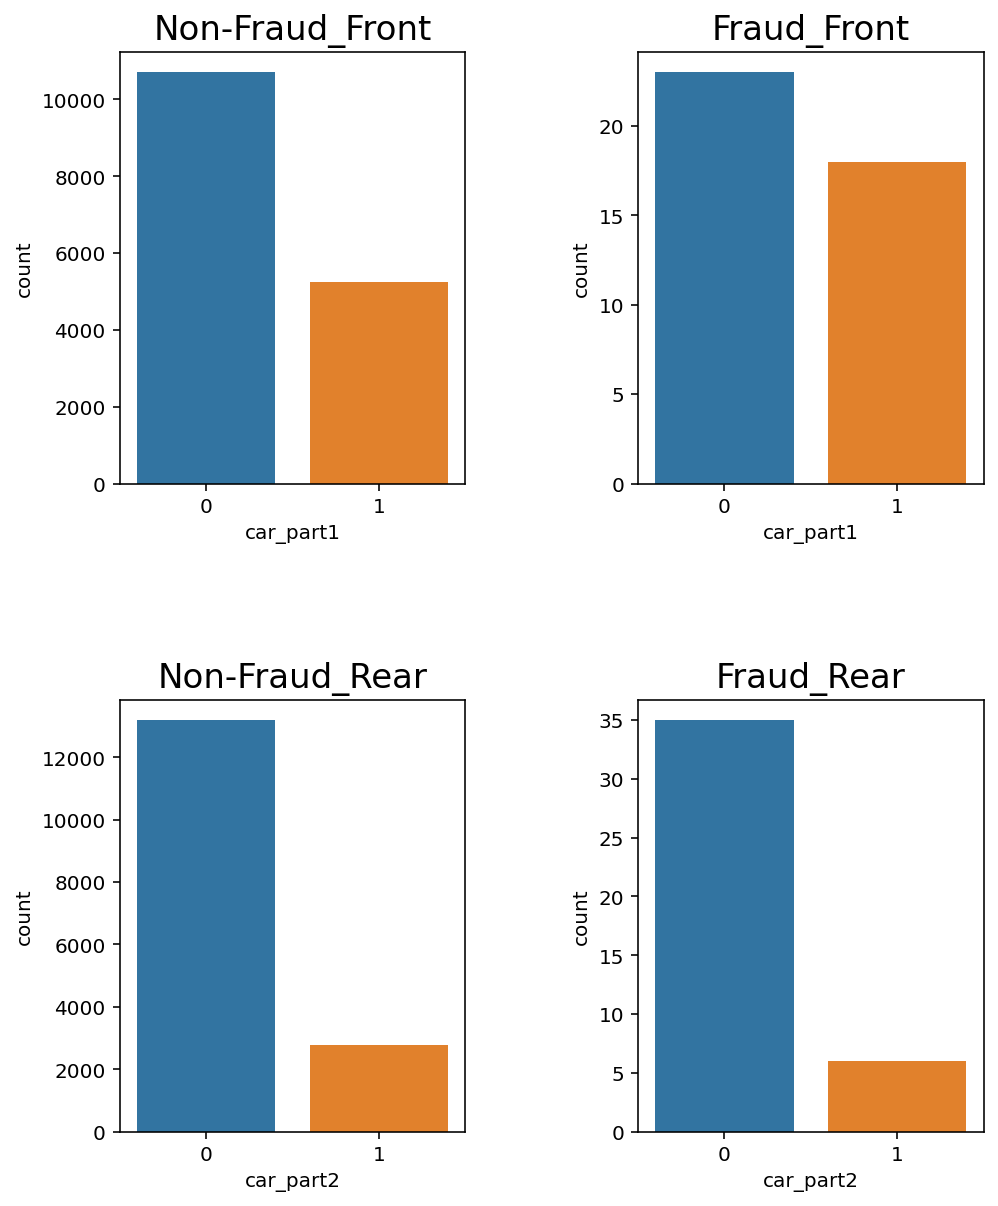

In [192]:
# car_part1,2 -> 전면부는 후면부 대비 비교적 컨트롤하기 쉬움. 잘 보이니까. 따라서 사기는 후면 대비 전면 손상비율이 높을 거라고 예상
fig, ax = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(left=100, right=101, top=2, bottom=None, wspace=.5, hspace=.5)

ax[0,0].set_title("Non-Fraud_Front", fontsize=17)
sns.countplot(x=fraud_no["car_part1"], ax=ax[0,0])

ax[1,0].set_title("Non-Fraud_Rear", fontsize=17)
sns.countplot(x=fraud_no["car_part2"], ax=ax[1,0])

ax[0,1].set_title("Fraud_Front", fontsize=17)
sns.countplot(x=fraud_yes["car_part1"], ax=ax[0,1])

ax[1,1].set_title("Fraud_Rear", fontsize=17)
sns.countplot(x=fraud_yes["car_part2"], ax=ax[1,1])

plt.show()

In [196]:
# 비사기, 전면부 손상 비율
round(fraud_no["car_part1"].value_counts() / len(fraud_no["car_part1"]) * 100, 2)

0    67.1
1    32.9
Name: car_part1, dtype: float64

In [215]:
# 사기, 전면부 손상 비율
round(fraud_yes["car_part1"].value_counts() / len(fraud_yes["car_part1"]) * 100, 2)

0    56.1
1    43.9
Name: car_part1, dtype: float64

In [216]:
# 비사기, 후면부 손상 비율
round(fraud_no["car_part2"].value_counts() / len(fraud_no["car_part2"]) * 100, 2)

0    82.67
1    17.33
Name: car_part2, dtype: float64

In [217]:
# 사기, 후면부 손상 비율
round(fraud_yes["car_part2"].value_counts() / len(fraud_yes["car_part2"]) * 100, 2)

0    85.37
1    14.63
Name: car_part2, dtype: float64

In [ ]:
# 후면부는 비중이 적은데, 전면부는 비중이 높다.. 고의성이 반영될 수 있는 지점으로 보임

In [213]:
# 전체건수 중 한곳이라도 손상입은 비율 (비사기)
round(len(fraud_no[(fraud_no["car_part1"] + fraud_no["car_part2"] != 0)]) / len(fraud_no) * 100, 2)

49.62

In [214]:
# 전체건수 중 한곳이라도 손상입은 비율 (비사기)
round(len(fraud_yes[(fraud_yes["car_part1"] + fraud_yes["car_part2"] != 0)]) / len(fraud_yes) * 100, 2)

58.54

In [ ]:
# 손상이 나야 보험금을 받는건가? 예를 들어서, 사고나도 손상이 없다고 판단되면 돈 안나오는 건지?

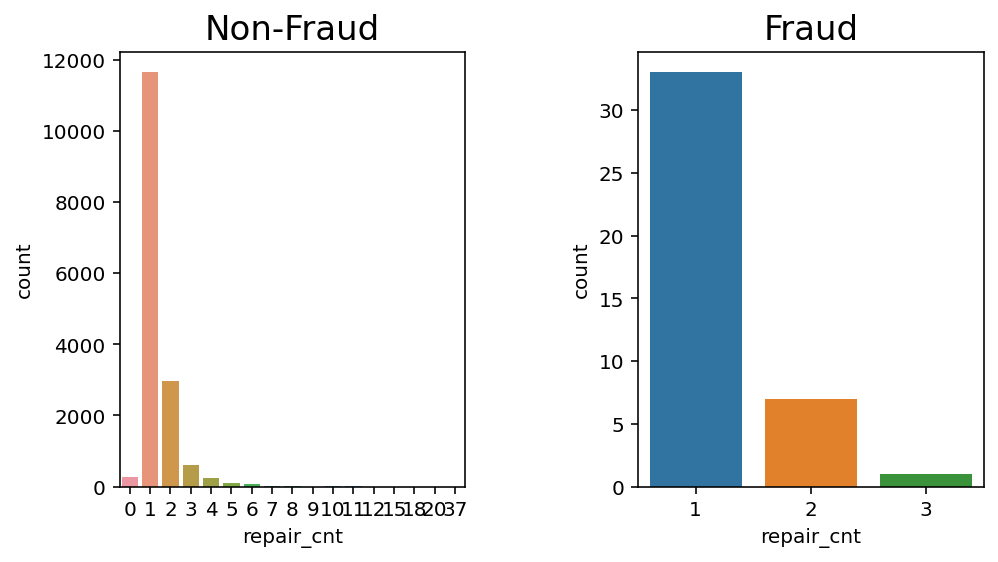

In [219]:
# repair_cnt -> 사기라면 목숨은 지키고 적당한 부상으로 보상받으려면 repair부위는 적게 내지 않았을까
# fraud에 0이 없는데, 전후면손상 있는데 수리부위개수는 없다는 게 이해가 안가는데...?
# 특이사항은 딱히 없는 듯
fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(left=2, right=3, wspace=.5)

ax[0].set_title("Non-Fraud", fontsize=17)
sns.countplot(x=fraud_no["repair_cnt"], ax=ax[0]) 


ax[1].set_title("Fraud", fontsize=17)
sns.countplot(x=fraud_yes["repair_cnt"], ax=ax[1])
plt.show()

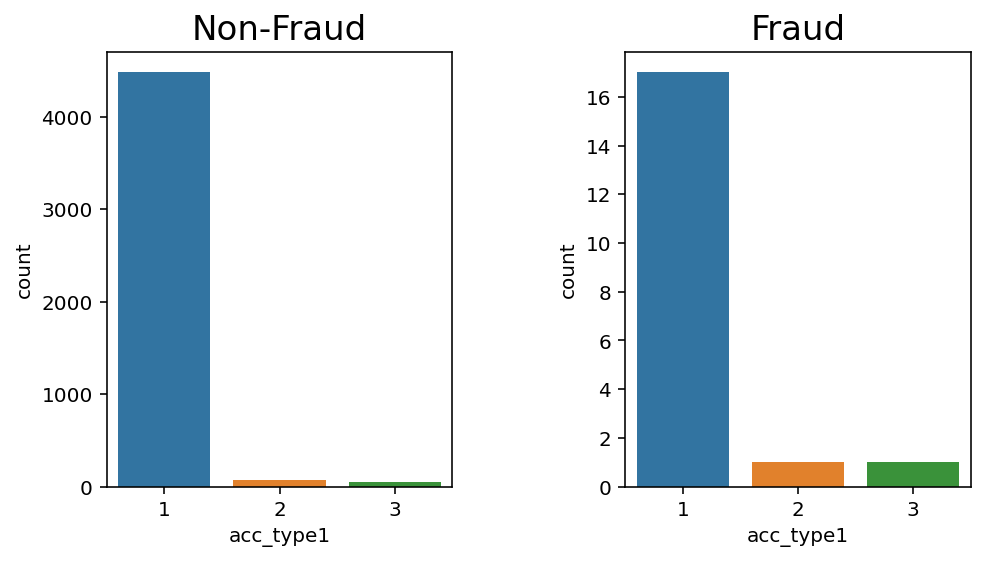

In [222]:
# acc_type -> 사기라면 차대차로 살짝, 혹은 주차장에서 단독이지 않을까 예상 (단독이면 보험금을 받을 수 있나..?)
# 0(미상) 값들이 너무 많았고, 제거했더니 특이사항은 안 보이는 듯함
fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(left=2, right=3, wspace=.5)

ax[0].set_title("Non-Fraud", fontsize=17)
sns.countplot(x=fraud_no[fraud_no["acc_type1"]!=0]["acc_type1"], ax=ax[0]) 


ax[1].set_title("Fraud", fontsize=17)
sns.countplot(x=fraud_yes[fraud_yes["acc_type1"]!=0]["acc_type1"], ax=ax[1])
plt.show()

In [ ]:
# accuracy와 precision이 중요하다고 생각됨 (recall보다는)
# 조금 찾아보니 비대칭데이터에서 accuracy 개념은 위험하다고 하네.. 그럼 precision위주?
# 이유는 보험사기를 아니라고 판정해서 조금 놓치는 것은 괜찮지만, 사기가 아닌데 사기라고 하는 건 고객관리 측면에서 손실위험이 크기 때문

# Memo

- 분석한 거, 궁금한 거, 기타 발견했던 아무거나 공유

### **** 승환 ****

- 사고시간, 대여기간, fraud_YN 비교하려했는데, 서로 feature간 다중공선성 체크했는데 다중공선성 우려  
    -> 얘네 어떻게 처리할 것인지? y를 어떻게 분류해볼까?
- 대여기간 긴 사람이 사고를 초반 or 후반인지 그 관계가 있는지 여부 -> '다중공선성 적용한 분류를 아직 잘 모르겠다'
- corr -> 특별한 건 안 보임 --> 좀 더 파 볼 예정


### **** 도겸 ****

- (기업이 예방차원에서 한다고 하면) 비즈니스 붙일거면 recall이 더 적합하지 않을까?
- precision이 정말 최선인가에 대한 의문?
- recall이 나을 수도 있는데, 이유는 서비스 전면말고 후면에서 조치를 취한다 하면 표본집단을 넓게 보고서 하는게 더 효율적이니까, 말이 되니까
- 전체랑 fraud랑 비율이 같은 거는 안 써도 되지 않을까?

- fraud=Yes인 값만 놓고 보려고 했다
- age_group별로 duration 분포를 봤을 때, 전체에서는 나이대별로 유사한 분포인 반면에, 사기에서는 그게 깨지는 모습을 보였다 -> 좀 더 보실 예정

In [39]:
fraud_yes.columns


Index(['fraud_YN', 'car_model', 'sharing_type', 'age_group',
       'has_previous_accident', 'cumulative_use_count', 'b2b',
       'accident_ratio', 'pf_type', 'socarpass', 'socarsave', 'start_hour',
       'duration', 'accident_hour', 'repair_cost', 'insure_cost',
       'accident_location', 'car_part1', 'car_part2', 'repair_cnt',
       'acc_type1', 'insurance_site_aid_YN', 'police_site_aid_YN',
       'total_prsn_cnt', 'test_set'],
      dtype='object')

In [45]:
yes_tmp = fraud_yes[["start_hour", "duration", "accident_hour"]]
yes_tmp[yes_tmp["duration"].values in [1,2,5]]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [56]:
yes_tmp["tmp"] = [1 if i in [1,2,5] else 0 for i in yes_tmp["duration"]]
yes_tmp = yes_tmp[yes_tmp["tmp"]==1]
yes_tmp.drop("tmp", axis=1, inplace=True)

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,start_hour,duration,accident_hour
18,1,2,1
83,6,2,2
100,4,2,4
143,2,1,1
163,5,2,5
230,4,1,4
364,4,1,5
383,2,2,2
417,6,1,6
436,4,1,4


In [59]:
print(yes_tmp.shape)
yes_tmp

(17, 3)


,start_hour,duration,accident_hour
18,1,2,1
83,6,2,2
100,4,2,4
143,2,1,1
163,5,2,5
230,4,1,4
364,4,1,5
383,2,2,2
417,6,1,6
436,4,1,4


In [63]:
yes_tmp[yes_tmp.duration ==1]

,start_hour,duration,accident_hour
143,2,1,1
230,4,1,4
364,4,1,5
417,6,1,6
436,4,1,4
496,5,1,2
528,4,1,4
5099,1,1,1
5647,3,1,4


In [64]:
yes_tmp[yes_tmp.duration ==2]

,start_hour,duration,accident_hour
18,1,2,1
83,6,2,2
100,4,2,4
163,5,2,5
383,2,2,2
451,5,2,5
512,5,2,5
4671,1,2,1


In [65]:
fraud_no[fraud_no.duration==2][["start_hour", "duration", "accident_hour"]]

,start_hour,duration,accident_hour
0,4,2,4
5,6,2,6
7,6,2,1
8,4,2,6
15,5,2,2
...,...,...,...
15975,6,2,6
15984,6,2,2
15986,4,2,5
15990,2,2,2


In [ ]:
# start, dur, acc hour 범주화 연속하게 재구성한다음, 차이값을 열로 만들고 그거의 분포 보기

In [71]:
# -1은 제거하고 봐보자
fraud_no.accident_hour.value_counts()

 2    4331
 1    3715
 6    3673
 5    2745
 4    1088
 3     371
-1      36
Name: accident_hour, dtype: int64

In [93]:
fraud_yes_hour = fraud_yes[["start_hour", "duration", "accident_hour"]]
fraud_no_hour = fraud_no[["start_hour", "duration", "accident_hour"]]

In [94]:
fraud_yes_hour["start_hour"].replace(2, 10, inplace=True)
fraud_yes_hour["start_hour"].replace(3, 2, inplace=True)
fraud_yes_hour["start_hour"].replace(4, 3, inplace=True)
fraud_yes_hour["start_hour"].replace(5, 4, inplace=True)
fraud_yes_hour["start_hour"].replace(6, 5, inplace=True)
fraud_yes_hour["start_hour"].replace(10, 6, inplace=True)

In [95]:
fraud_yes_hour["accident_hour"].replace(2, 10, inplace=True)
fraud_yes_hour["accident_hour"].replace(3, 2, inplace=True)
fraud_yes_hour["accident_hour"].replace(4, 3, inplace=True)
fraud_yes_hour["accident_hour"].replace(5, 4, inplace=True)
fraud_yes_hour["accident_hour"].replace(6, 5, inplace=True)
fraud_yes_hour["accident_hour"].replace(10, 6, inplace=True)

In [96]:
fraud_no_hour["start_hour"].replace(2, 10, inplace=True)
fraud_no_hour["start_hour"].replace(3, 2, inplace=True)
fraud_no_hour["start_hour"].replace(4, 3, inplace=True)
fraud_no_hour["start_hour"].replace(5, 4, inplace=True)
fraud_no_hour["start_hour"].replace(6, 5, inplace=True)
fraud_no_hour["start_hour"].replace(10, 6, inplace=True)

In [97]:
fraud_no_hour["accident_hour"].replace(2, 10, inplace=True)
fraud_no_hour["accident_hour"].replace(3, 2, inplace=True)
fraud_no_hour["accident_hour"].replace(4, 3, inplace=True)
fraud_no_hour["accident_hour"].replace(5, 4, inplace=True)
fraud_no_hour["accident_hour"].replace(6, 5, inplace=True)
fraud_no_hour["accident_hour"].replace(10, 6, inplace=True)

In [101]:
fraud_no_hour.shape

(15959, 3)

In [102]:
fraud_no_hour[fraud_no_hour["accident_hour"]==-1].shape

(36, 3)

In [107]:
# -1 행삭제
fraud_no_hour.drop(fraud_no_hour[fraud_no_hour.accident_hour==-1].index, inplace=True)

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [108]:
fraud_no_hour.shape

(15923, 3)

In [124]:
fraud_yes_hour_dur12 = fraud_yes_hour[fraud_yes_hour.duration <= 2]
fraud_yes_hour_dur12

,start_hour,duration,accident_hour
18,1,2,1
83,5,2,6
100,3,2,3
143,6,1,1
163,4,2,4
230,3,1,3
364,3,1,4
383,6,2,6
417,5,1,5
436,3,1,3


In [126]:
fraud_no_hour.duration.value_counts()

1    5709
3    4835
2    3218
4    1585
5     576
Name: duration, dtype: int64

In [146]:
fraud_no_hour_dur125 = fraud_no_hour[(fraud_no_hour.duration <= 2) | (fraud_no_hour.duration==5)]
fraud_no_hour_dur125

,start_hour,duration,accident_hour
0,3,2,3
4,1,1,1
5,5,2,5
7,5,2,1
8,3,2,5
...,...,...,...
15994,3,1,3
15995,1,1,1
15996,4,2,5
15998,5,1,6


In [152]:
# 1~6의 갭은 1로 조정
fraud_yes_hour_dur12["gap_start_acci"] = fraud_yes_hour_dur12["accident_hour"] - fraud_yes_hour_dur12["start_hour"]
fraud_yes_hour_dur12["gap_start_acci"].replace(-5, 1, inplace=True)
fraud_yes_hour_dur12

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/pandas/core/series.py:4515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,start_hour,duration,accident_hour,gap_start_acci
18,1,2,1,0
83,5,2,6,1
100,3,2,3,0
143,6,1,1,1
163,4,2,4,0
230,3,1,3,0
364,3,1,4,1
383,6,2,6,0
417,5,1,5,0
436,3,1,3,0


In [171]:
sorted(fraud_yes_hour_dur12.gap_start_acci.unique())

[0, 1, 2]

In [169]:
# 갭이 -인 값들이 있어, 6더하고 6으로 나눈 나머지를 값으로 조정
fraud_no_hour_dur125["gap_start_acci"] = fraud_no_hour_dur125["accident_hour"] - fraud_no_hour_dur125["start_hour"]
fraud_no_hour_dur125["gap_start_acci"] = (fraud_no_hour_dur125["gap_start_acci"] + 6) % 6
fraud_no_hour_dur125

/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/limhyunsoo/opt/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,start_hour,duration,accident_hour,gap_start_acci
0,3,2,3,0
4,1,1,1,0
5,5,2,5,0
7,5,2,1,2
8,3,2,5,2
...,...,...,...,...
15994,3,1,3,0
15995,1,1,1,0
15996,4,2,5,1
15998,5,1,6,1


# duration이 짧은데, 그것보다 gap이 더 큰 경우가 있다. 처리 어떻게..?

In [173]:
fraud_no_hour_dur125[fraud_no_hour_dur125.gap_start_acci == 5]

,start_hour,duration,accident_hour,gap_start_acci
209,2,1,1,5
268,2,1,1,5
304,6,5,5,5
532,1,5,6,5
590,6,1,5,5
3893,6,1,5,5
4158,1,2,6,5
4782,2,2,1,5
5078,6,5,5,5
5178,5,2,4,5


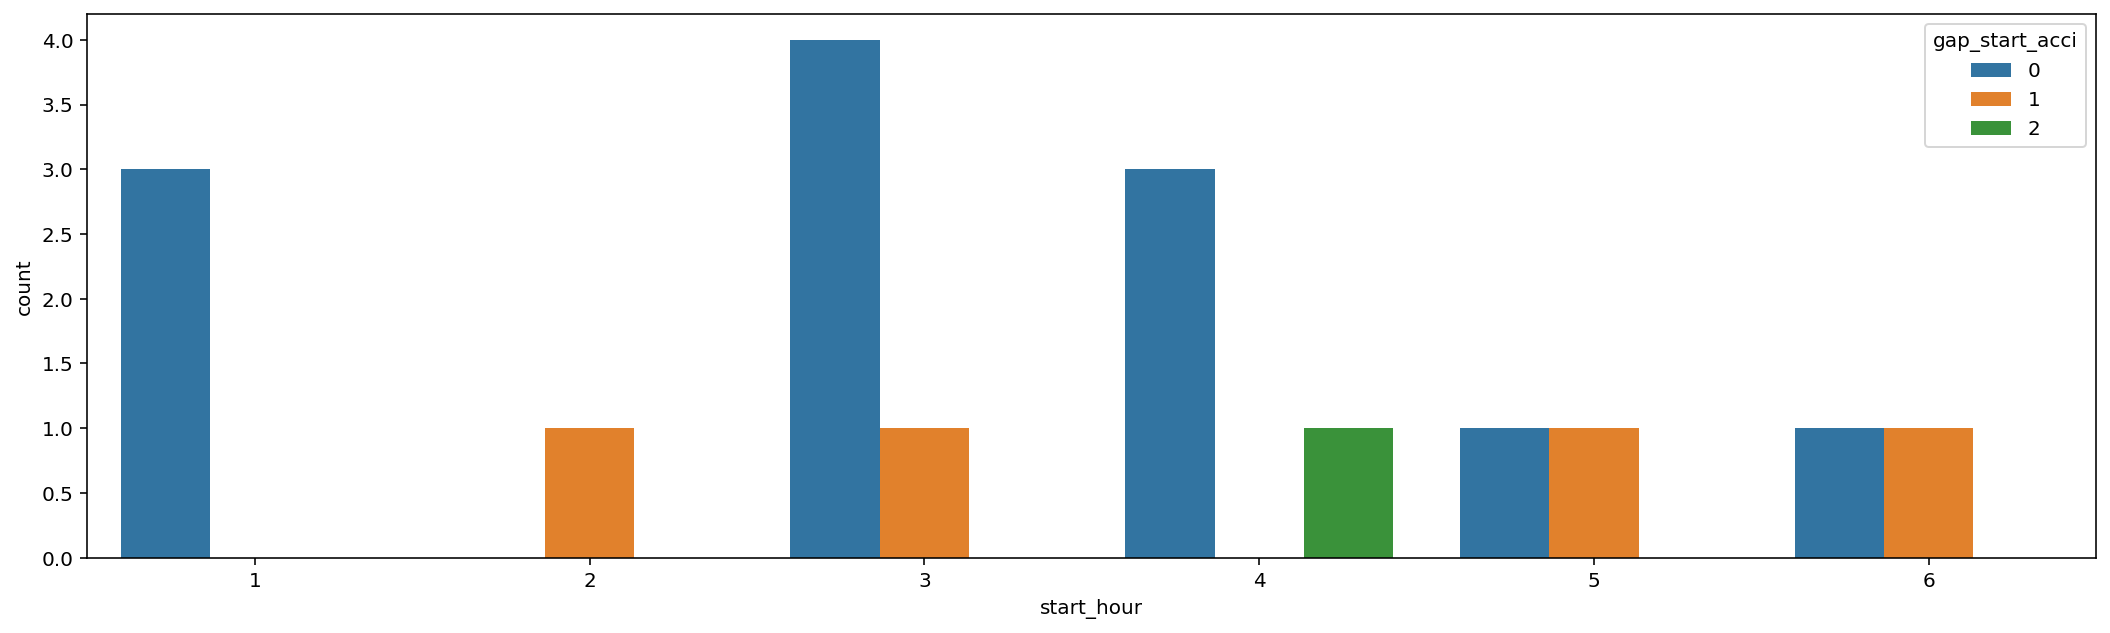

In [206]:
plt.figure(figsize=(18,5))
sns.countplot(x="start_hour", hue="gap_start_acci", data=fraud_yes_hour_dur12);

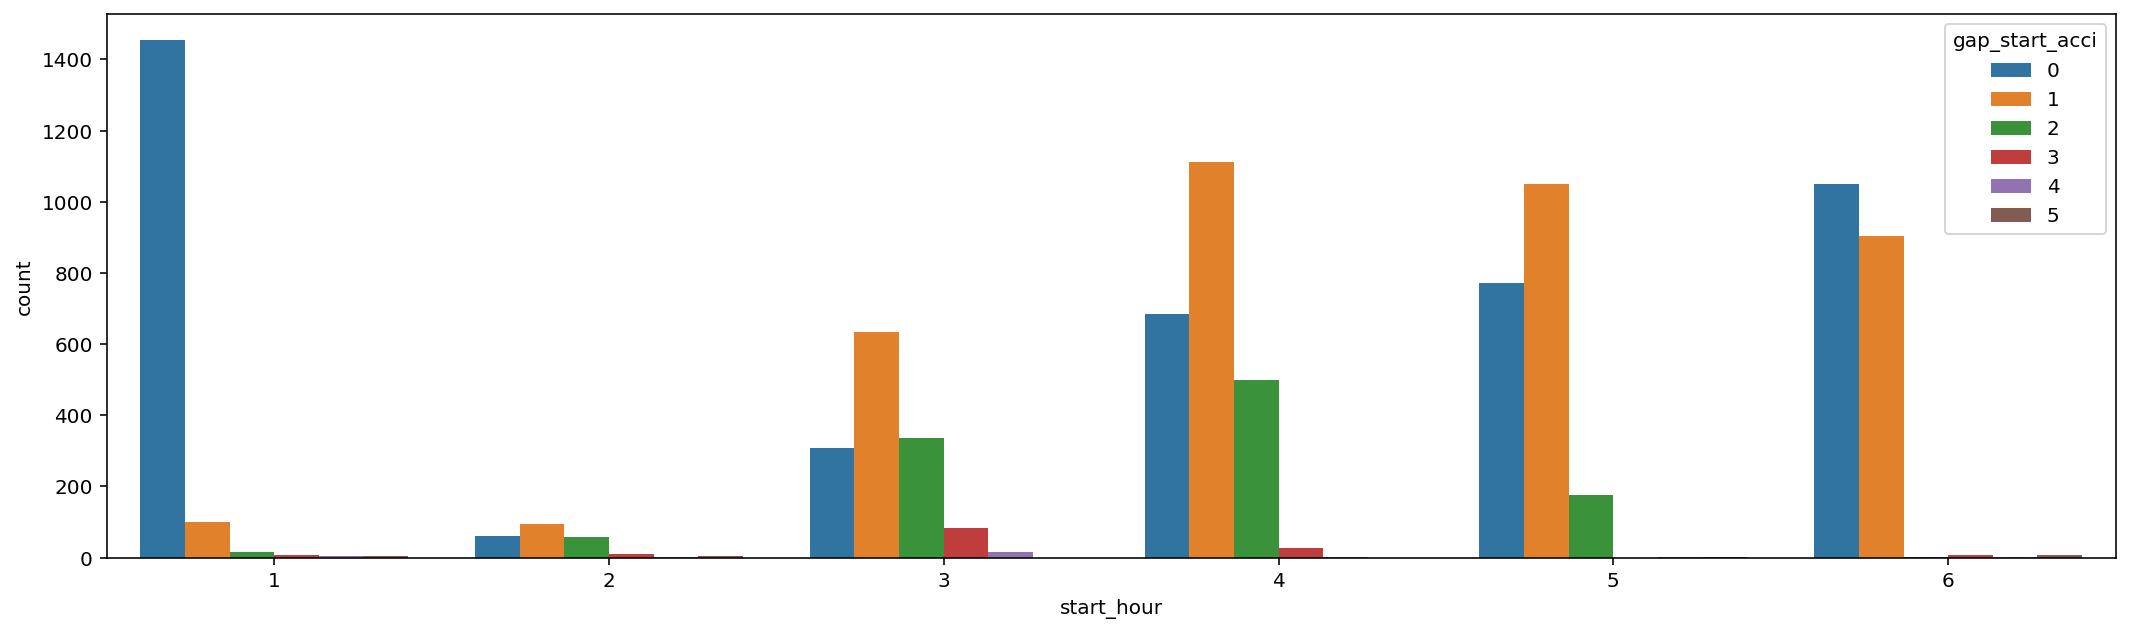

In [192]:
plt.figure(figsize=(18,5))
sns.countplot(x="start_hour", hue="gap_start_acci", data=fraud_no_hour_dur125);

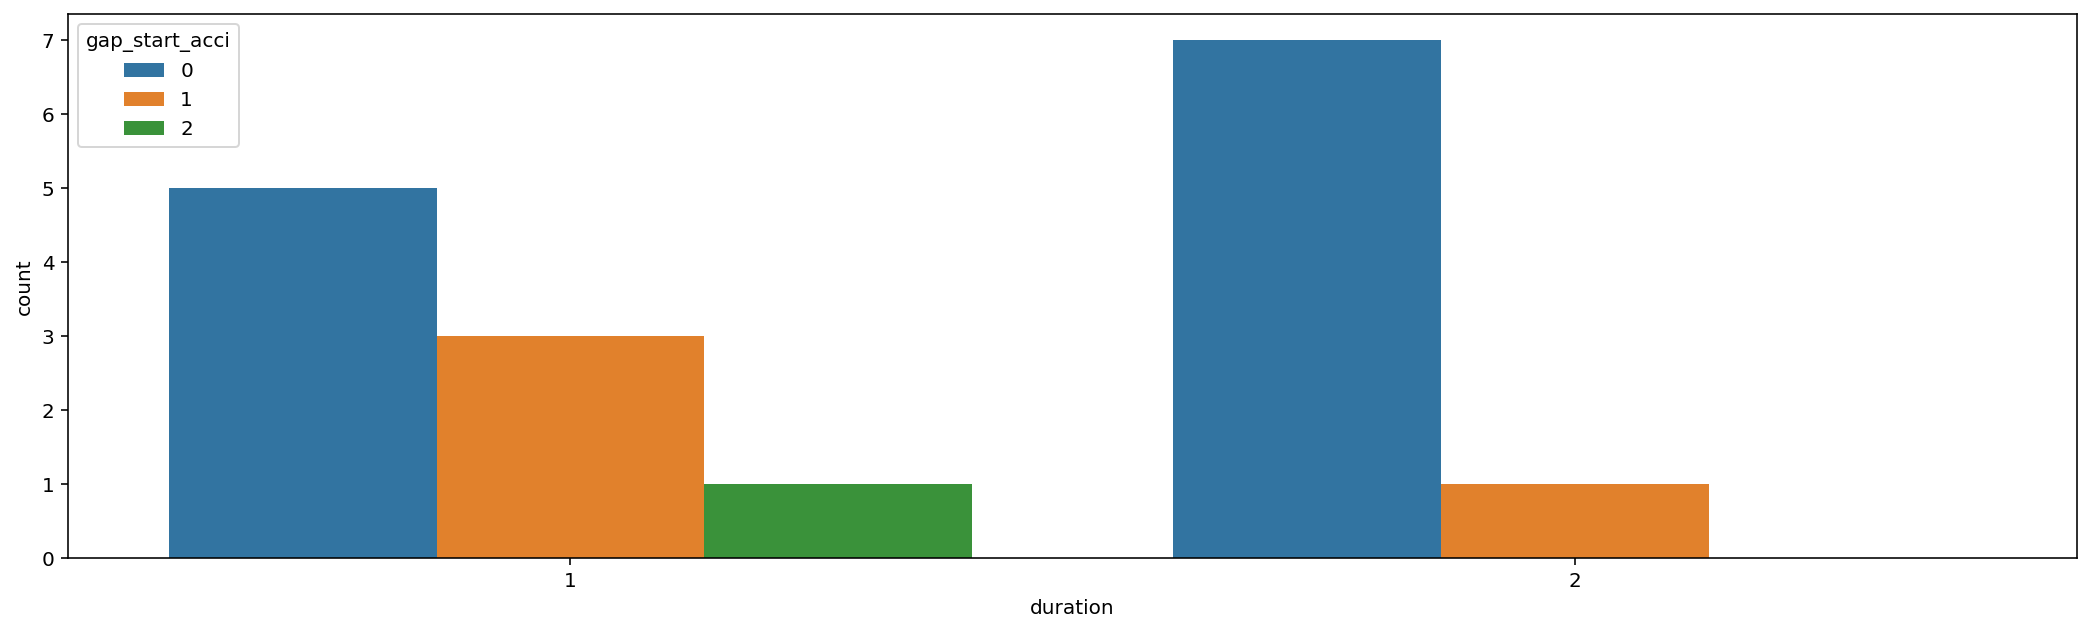

In [194]:
plt.figure(figsize=(18,5))
sns.countplot(x="duration", hue="gap_start_acci", data=fraud_yes_hour_dur12);

# 아래처럼 실제로 시간차이는 얼마 안나는데 gap이 커보이는 데이터 한계가 있다.. 1같은 경우 다른 범주 2개 합친 범위..

In [196]:
fraud_yes_hour_dur12[fraud_yes_hour_dur12["gap_start_acci"]==2]

,start_hour,duration,accident_hour,gap_start_acci
496,4,1,6,2


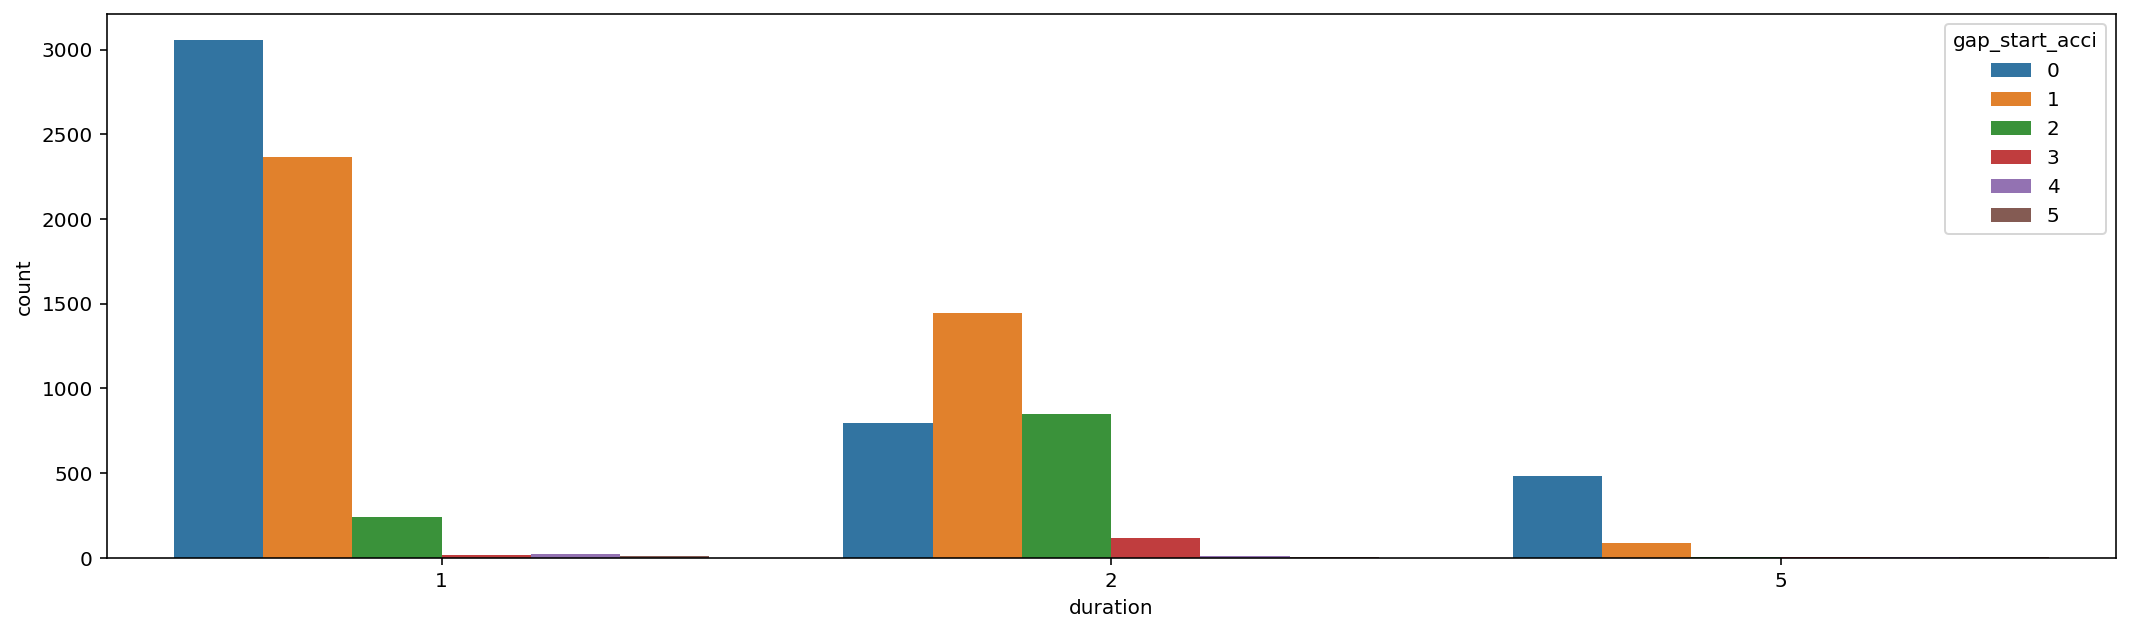

In [195]:
plt.figure(figsize=(18,5))
sns.countplot(x="duration", hue="gap_start_acci", data=fraud_no_hour_dur125);